# P05 - FORECASTING

In [1]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig, show, subplots
from ts_functions import HEIGHT, PREDICTION_MEASURES, split_dataframe, create_temporal_dataset, split_temporal_data, plot_evaluation_results, plot_forecasting_series
from ds_charts import multiple_line_chart, HEIGHT, plot_overfitting_study, bar_chart
from sklearn.base import RegressorMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from torch import zeros
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.autograd import Variable


%run p00_settings.ipynb

In [2]:
data_file = ts_transf_data_file if ts_transf else prepared_out_data_file
flat_data: DataFrame = read_csv(project_path + data_file, index_col=time_var, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)

In [3]:
data = DataFrame(flat_data[target])
print(data.head())

               PM2.5
date                
2013-03-01 -0.922022
2013-03-02 -0.526798
2013-03-03 -0.188117
2013-03-04 -0.702259
2013-03-05  0.503235


Having the right data format, we can split it into train and test. But now we will be doing it with dataframes instead of ndarrays, to be able to use all of its methods...

In [4]:
trnX, tstX, trnY, tstY = split_temporal_data(data, target, trn_pct=0.7)

In [5]:
train, test = split_dataframe(data, trn_pct=0.75)

The function plot_forecasting_series is able to plot the training and testing data, along with their predictions.

In [6]:
def plot_forecasting_series(trn, tst, prd_trn, prd_tst, figname: str, x_label: str = 'time', y_label:str =''):
    _, ax = subplots(1,1,figsize=(5*HEIGHT, HEIGHT), squeeze=True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(figname)
    ax.plot(trn.index, trn, label='train', color='b')
    ax.plot(trn.index, prd_trn, '--y', label='train prediction')
    ax.plot(tst.index, tst, label='test', color='g')
    ax.plot(tst.index, prd_tst, '--r', label='test prediction')
    ax.legend(prop={'size': 5})


measure = 'R2'
flag_pct = False
eval_results = {}

## 01 - Basic Forecasting Models

### 01.1 - Simple Average

The Simple Average regressor is the easiest to implement, allways predicting the outcome to be the data mean value. For implementing it, next we have a simple extension of the sklearn class RegressorMixin, by redifining the fit and predict methods.

{'SimpleAvg': -0.007063653709368456}
{'RMSE': [0.8470854305443688, 0.8800242470362788], 'MAE': [0.6403182437176772, 0.6381674564658119]} {'R2': [1.1102230246251565e-16, -0.007063653709368456]}


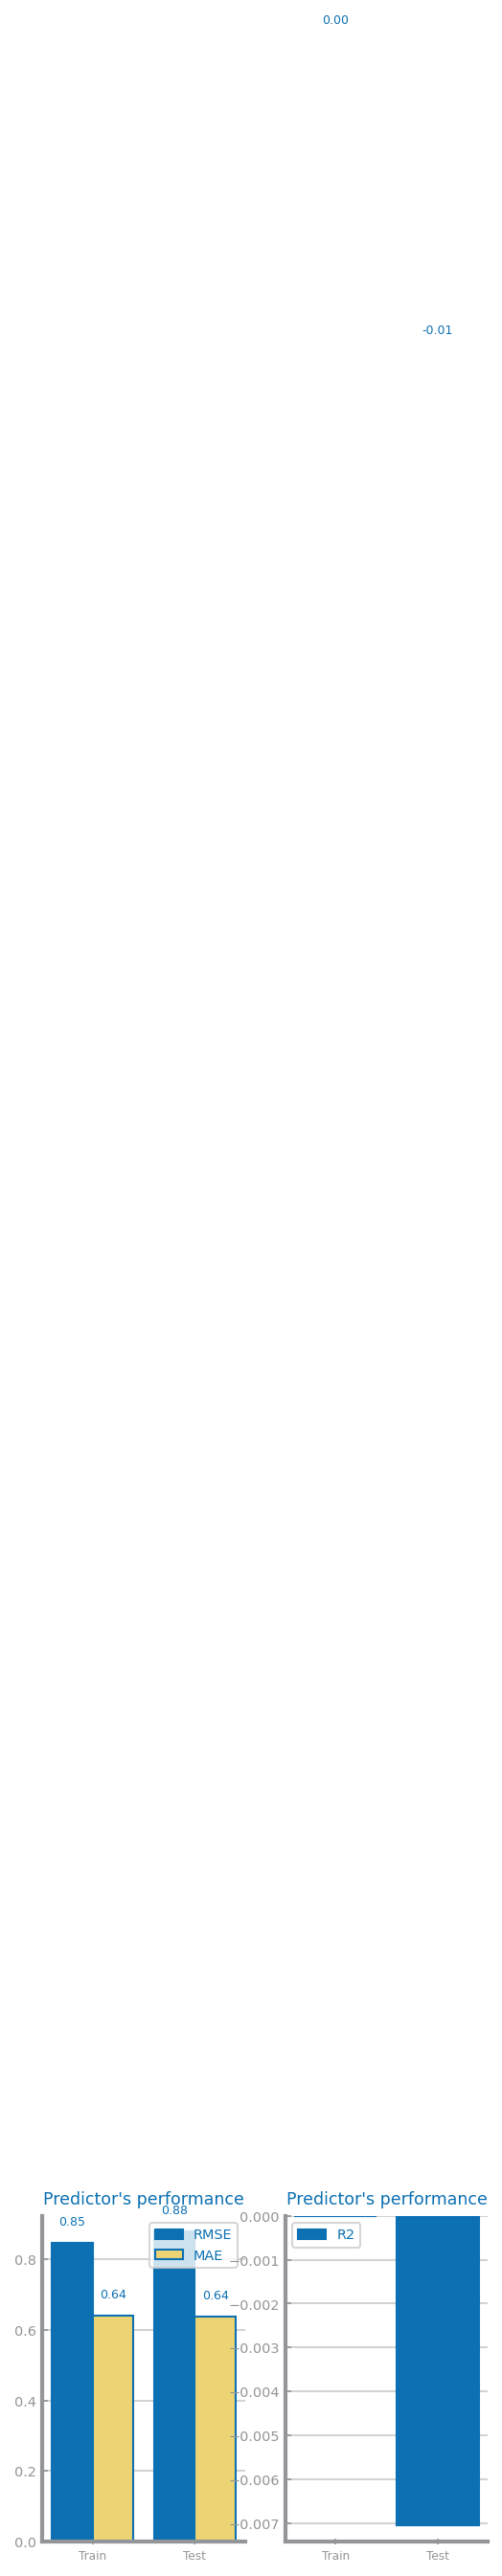

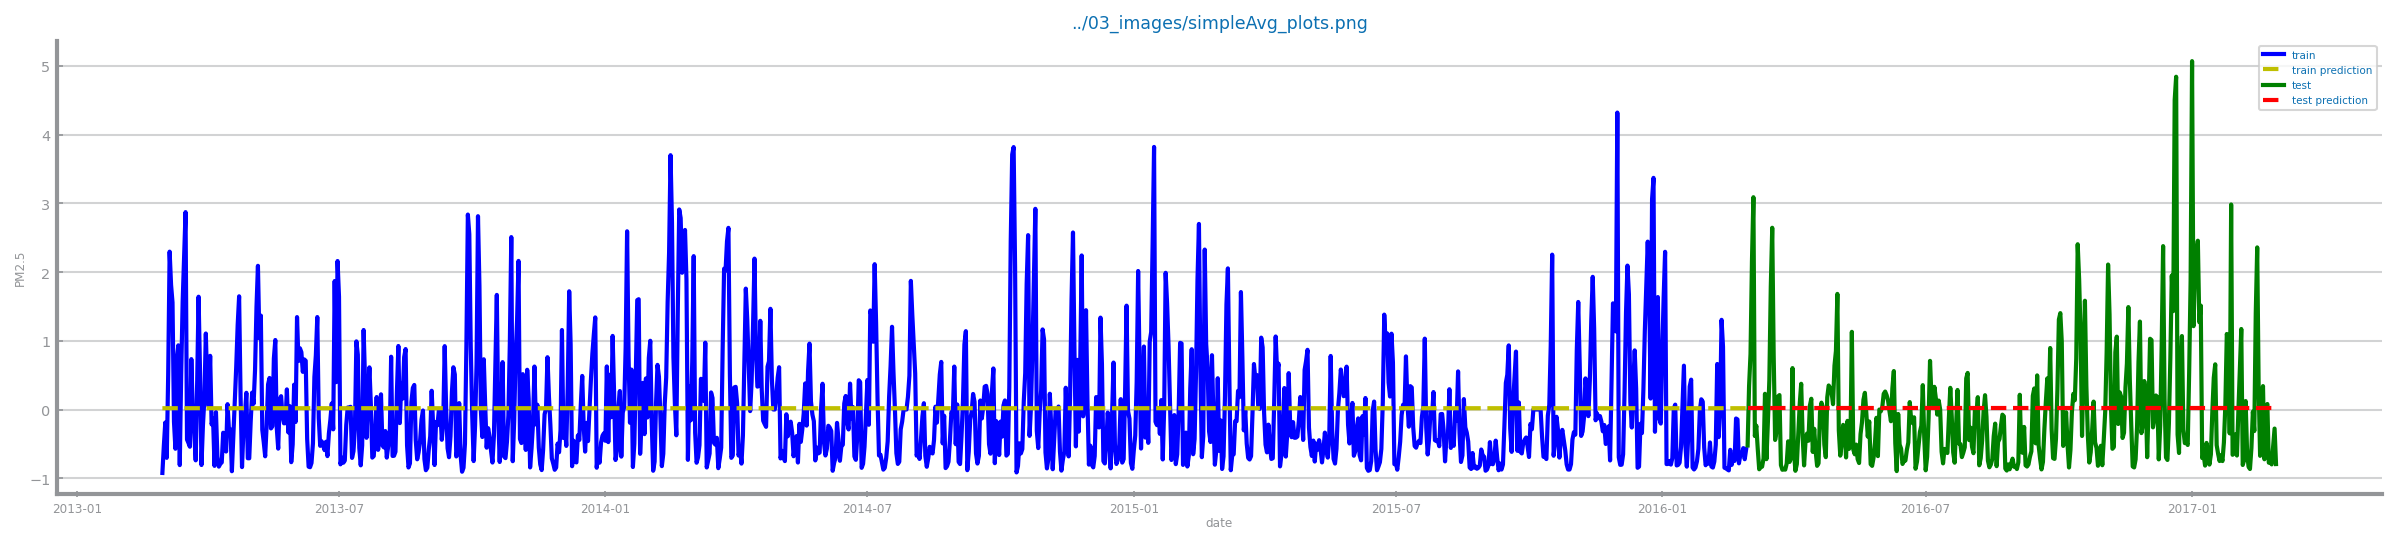

In [7]:
class SimpleAvgRegressor (RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean = 0

    def fit(self, X: DataFrame):
        self.mean = X.mean()

    def predict(self, X: DataFrame):
        prd =  len(X) * [self.mean]
        return prd

fr_mod = SimpleAvgRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['SimpleAvg'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'../03_images/simpleAvg_eval.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'../03_images/simpleAvg_plots.png', x_label=time_var, y_label=target)

### 01.2 - Persistence Model
The Persistence model just predicts the outcome to be the same as the last value seen. Again, for implementing it, we extended the sklearn class RegressorMixin, by redifining the fit and predict again.

-0.5745976847591773
{'SimpleAvg': -0.007063653709368456, 'Persistence': 0.12072833235222058}
{'RMSE': [0.7968752006895917, 0.8222951277064399], 'MAE': [0.5588325011866474, 0.5287249682138224]} {'R2': [0.11503478847906856, 0.12072833235222058]}


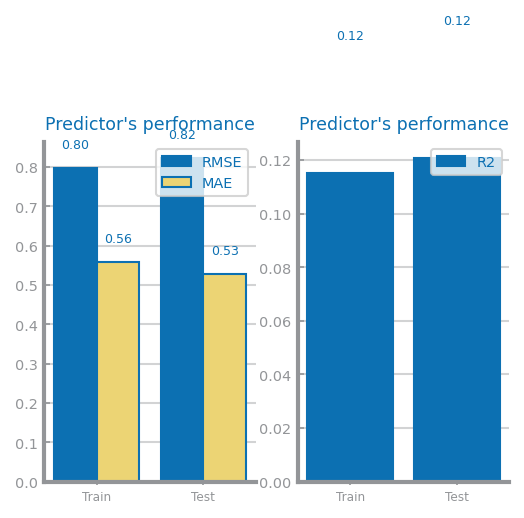

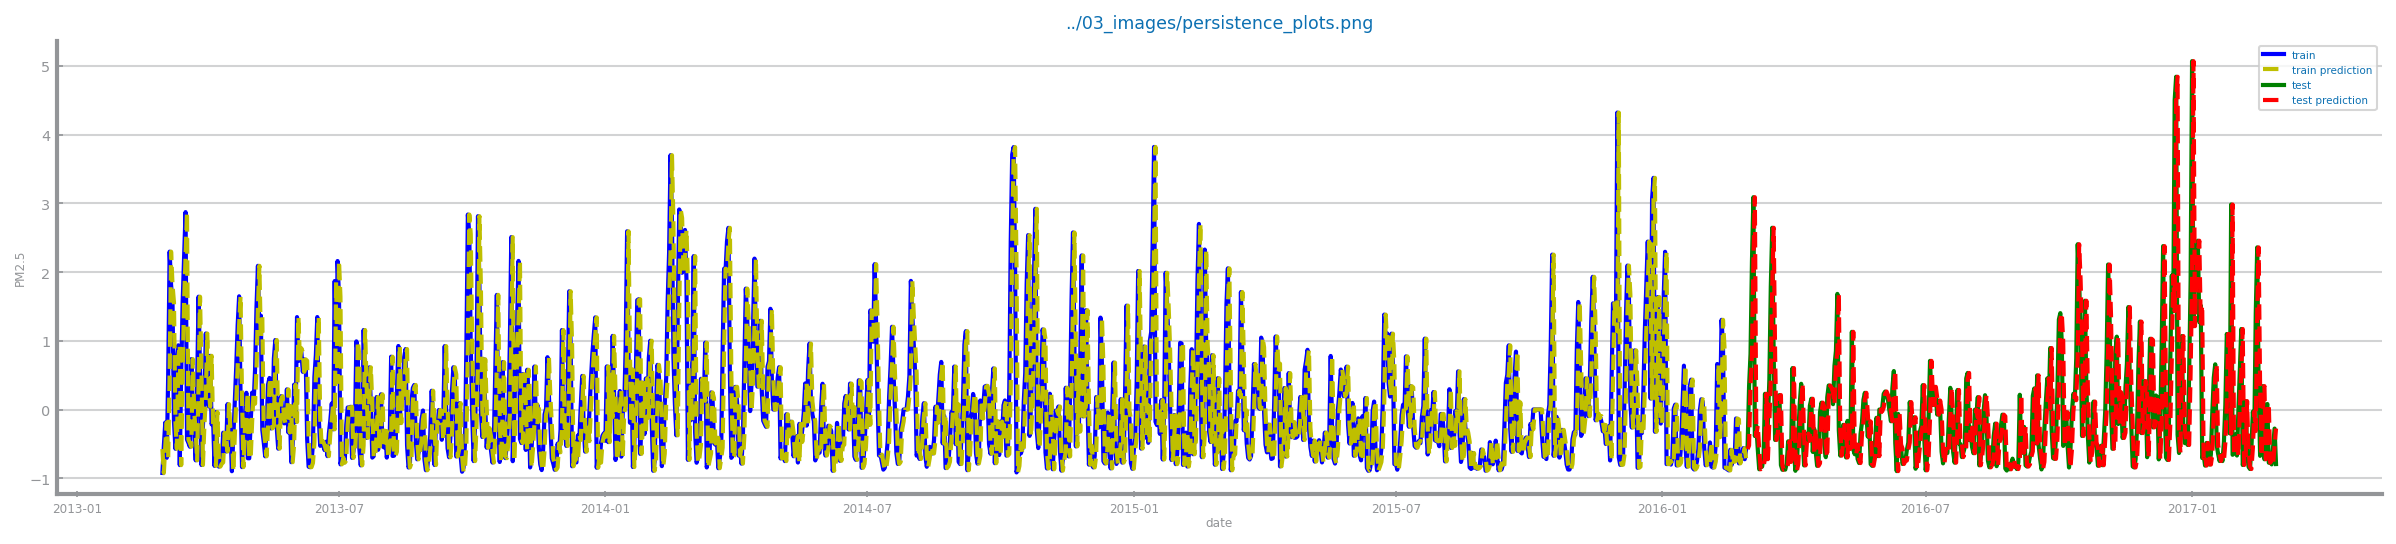

In [8]:
class PersistenceRegressor (RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0

    def fit(self, X: DataFrame):
        self.last = X.iloc[-1,0]
        print(self.last)

    def predict(self, X: DataFrame):
        prd = X.shift().values
        prd[0] = self.last
        return prd

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'../03_images/persistence_eval.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'../03_images/persistence_plots.png', x_label=time_var, y_label=target)

### 01.3 - Rolling Mean
The RoolingMean technique, uses a sliding window with size win and computing its mean value for predicting the next value.

{'SimpleAvg': -0.007063653709368456, 'Persistence': 0.12072833235222058, 'RollingMean': 0.5617310645970089}
{'RMSE': [0.5765899550731277, 0.5805458458047364], 'MAE': [0.42061310973727417, 0.40728293332977483]} {'R2': [0.5366814163899165, 0.5617310645970089]}


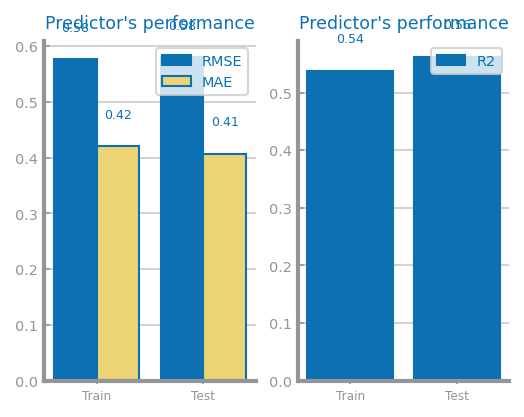

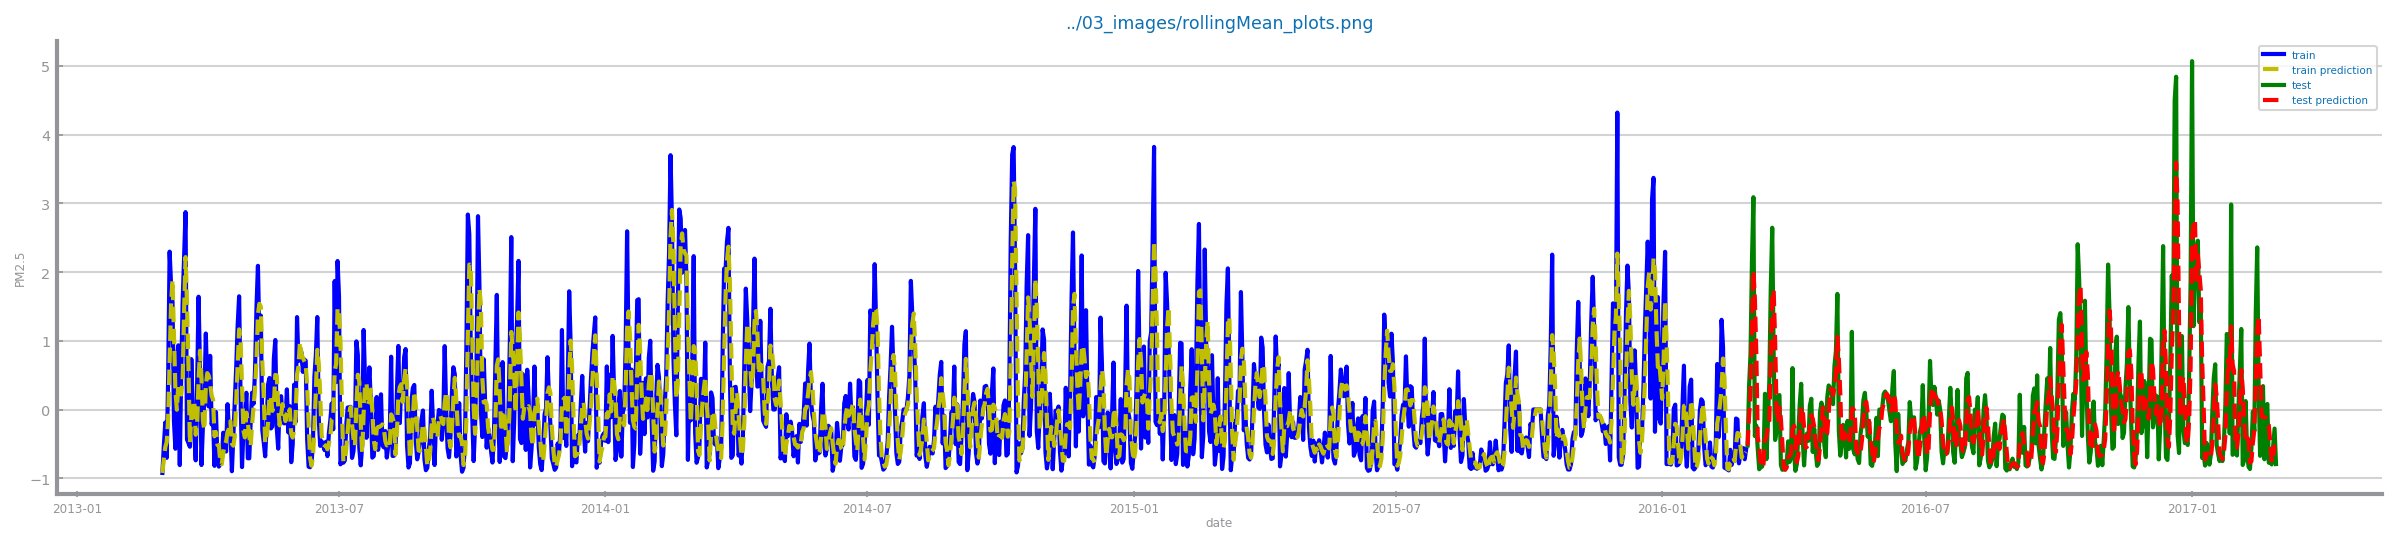

In [9]:
class RollingMeanRegressor (RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win

    def fit(self, X: DataFrame):
        None

    def predict(self, X: DataFrame):
        prd = len(X) * [0]
        for i in range(len(X)):
            prd[i] = X[max(0, i-self.win_size+1):i+1].mean()
        return prd

fr_mod = RollingMeanRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['RollingMean'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'../03_images/rollingMean_eval.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'../03_images/rollingMean_plots.png', x_label=time_var, y_label=target)

And now, we may compare the different results from the different regressors...

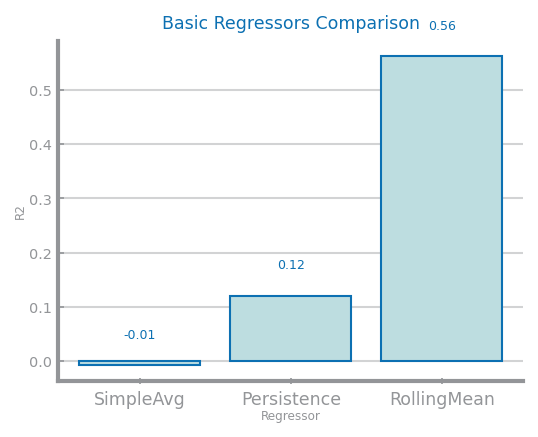

In [10]:
figure()
bar_chart(list(eval_results.keys()), list(eval_results.values()), title = 'Basic Regressors Comparison', xlabel= 'Regressor', ylabel=measure, percentage=flag_pct, rotation = False)

## 02 - KNN

The adaptation of KNN to deal with predicition is straightforward, and resumes to predict the value to the average value of the target variable for its K nearest neighbors. In this context and in Python, they are implemented through the KNeighborsRegressor in the sklearn.neighbors.. And its use is similar for both classification and prediction.

As before, the number of neighbors to consider and the distance function to use to choose the neighbors, are given through n_neighbors and metric parameters. Note that in this context, weighting the influence of each neighbor according to its distance to the object to predict, might also be interesting, which may be done through the weights parameter.

In [11]:
if temporal_windows_df:
  data = create_temporal_dataset(data, target, nr_instants, project_path + temp_window_data_file)
else:
  data = data

In [12]:
trnX, tstX, trnY, tstY = split_temporal_data(data, target, trn_pct=0.7)

In [13]:
weights = ['uniform', 'distance']
dist = ['manhattan', 'euclidean', 'chebyshev']
kvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
measure = 'R2'
flag_pct = False
best = ('',  0, 0.0)
last_best = -100000
best_model = None
ncols = len(weights)

In [29]:
DataFrame(trnY)

,0
0,-0.922022
1,-0.526798
2,-0.188117
3,-0.702259
4,0.503235
...,...
1017,0.861735
1018,0.305745
1019,-0.846825
1020,-0.830503


ValueError: Found array with 0 feature(s) (shape=(1022, 0)) while a minimum of 1 is required.

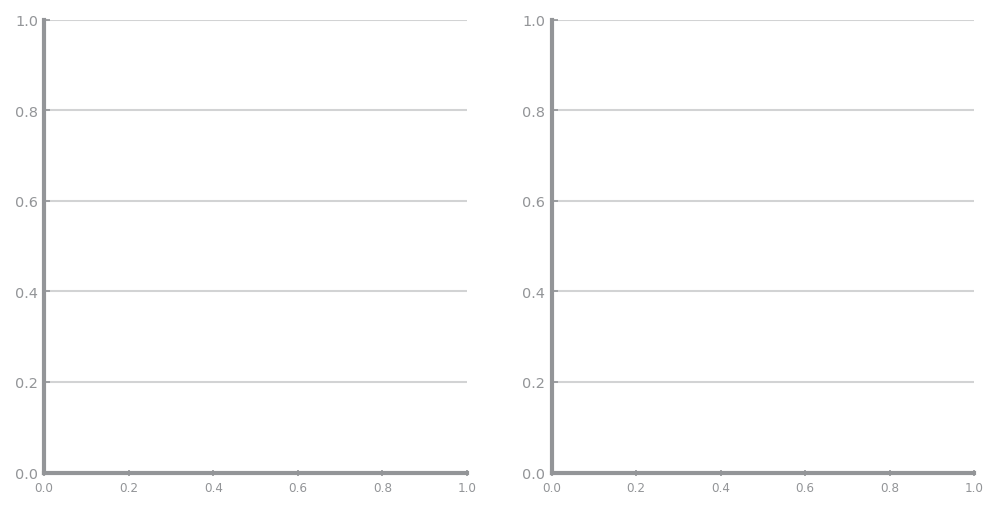

In [14]:
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for wei in range(len(weights)):
    w = weights[wei]
    values = {}
    for d in dist:
        yvalues = []
        for k in kvalues:
            pred = KNeighborsRegressor(n_neighbors=k, metric=d, weights=w)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (w, d, k)
                last_best = yvalues[-1]
                best_model = pred

        values[d] = yvalues
    multiple_line_chart(
        kvalues, values, ax=axs[0, wei], title=f'KNN with {w} weight', xlabel='K', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_knn_study.png')
show()
print(f'Best results achieved with {best[0]} weight, dist={best[1]} and K={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

In [15]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_knn_best.png')

AttributeError: 'NoneType' object has no attribute 'predict'

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

In [16]:
y_tst_values = []
y_trn_values = []
for k in kvalues:
    pred = KNeighborsRegressor(n_neighbors=k, metric=best[1], weights=best[0])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(kvalues, y_trn_values, y_tst_values, name=f'ts_knn_{best[0]}_{best[1]}', xlabel='K', ylabel=measure, pct=flag_pct)

ValueError: Metric '0' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

## 03 - Regression Trees

Regression Trees are trees to deal with predicition. In this context and in Python, they are implemented through the DecisionTreeRegressor in the sklearn.tree. And its use is similar for both classification and prediction. Leafs on Regression Trees are just the average value of the target variable for the subset of training records reaching the leaf.

In [17]:
criteria = ['squared_error', 'friedman_mse', 'absolute_error']
max_depths = [2, 5, 7, 10, 12, 15, 17, 20, 22, 25]
min_impurity_decrease = [0.01, 0.001, 0.0001]

measure = 'R2'
flag_pct = False
best = ('',  0, 0.0)
last_best = -10000
best_model = None
ncols = len(criteria)

ValueError: Found array with 0 feature(s) (shape=(1022, 0)) while a minimum of 1 is required.

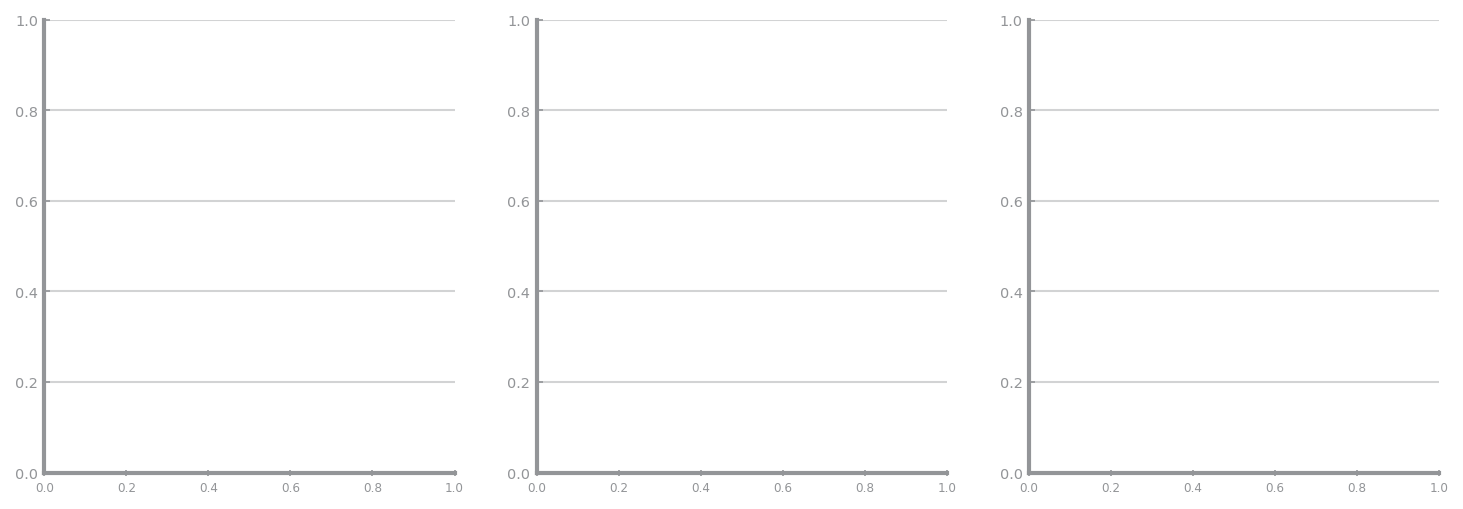

In [18]:
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(criteria)):
    crit = criteria[k]
    values = {}
    for imp in min_impurity_decrease:
        yvalues = []
        for d in max_depths:
            # print(f'DT - {crit} criteria, min_impurity_decrease={imp} and depth={d}')
            pred = DecisionTreeRegressor(max_depth=d, criterion=crit, min_impurity_decrease=imp)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (crit, imp, d)
                last_best = yvalues[-1]
                best_model = pred

        values[imp] = yvalues
    multiple_line_chart(
        max_depths, values, ax=axs[0, k], title=f'Decision Trees with {crit} criteria',
        xlabel='max_depth', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_dt_study.png')
show()
print(f'Best results achieved with {best[0]} criteria, min_impurity_decrease={best[1]} and depth={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

In [19]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_tree_best.png')

AttributeError: 'NoneType' object has no attribute 'predict'

Like for classification, we may visualize our tree ...

In [20]:
tree.plot_tree(best_model, feature_names=data.columns)
savefig(f'../03_images/ts_tree_best_tree.png')

TypeError: None is not an estimator instance.

and the performance of our predictor, studying its overfitting.

In [21]:
y_tst_values = []
y_trn_values = []
for d in max_depths:
    pred = DecisionTreeRegressor(max_depth=d, criterion=best[0], min_impurity_decrease=best[1])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(max_depths, y_trn_values, y_tst_values, name=f'ts_tree_{best[0]}_{best[1]}', xlabel='max depth', ylabel=measure, pct=flag_pct)

ValueError: Found array with 0 feature(s) (shape=(1022, 0)) while a minimum of 1 is required.

## 04 - Random Forests

As in classification, Random Forests, implemented through the RandomForestRegressor in the sklearn.ensemble package, are one of the most powerful prediction techniques, simple and easy to apply.

It trains a set of n regression trees, that are combined in an ensemble of n_estimators. Each tree, however, is trained over a different subset of the original training data, first by choosing a subset of k variables describing the data, with k determined by the max_features parameter. Beside many other parameters we can choose the maximum size of each tree and the splitting criteria, through max_depth and criterion parameter.

Next, we can see the results achieved by a set of parameters combinations.

In [22]:
max_features = [.25, .75]
max_depths = [5, 10, 15, 20, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]

measure = 'R2'
flag_pct = False
best = ('',  0, 0.0)
last_best = -10000
best_model = None
ncols = len(max_features)

ValueError: Found array with 0 feature(s) (shape=(1022, 0)) while a minimum of 1 is required.

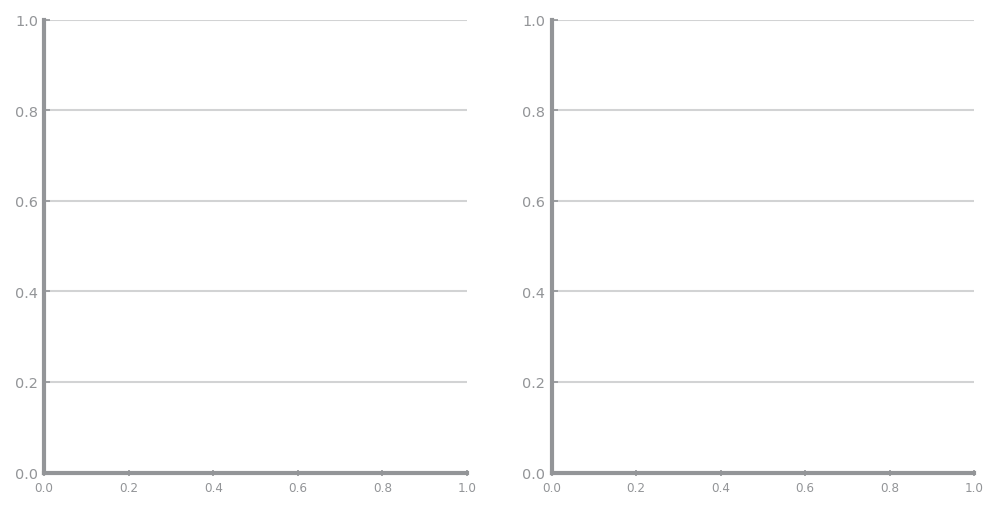

In [23]:
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for nf in range(len(max_features)):
    f = max_features[nf]
    values = {}
    for d in max_depths:
        yvalues = []
        for n in n_estimators:
            # print(f'RF - max_features={f} depth={d} and nr_estimators={n}')
            pred = RandomForestRegressor(n_estimators=n, max_depth=d, max_features=f)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (f, d, n)
                last_best = yvalues[-1]
                best_model = pred

        values[d] = yvalues
    multiple_line_chart(
        n_estimators, values, ax=axs[0, nf], title=f'Random Forests with {f} max features', xlabel='nr estimators', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_rf_study.png')
show()
print(f'Best results achieved with {best[0]} max features, depth={best[1]} and nr estimators={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

In [24]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_rf_best.png')

AttributeError: 'NoneType' object has no attribute 'predict'

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

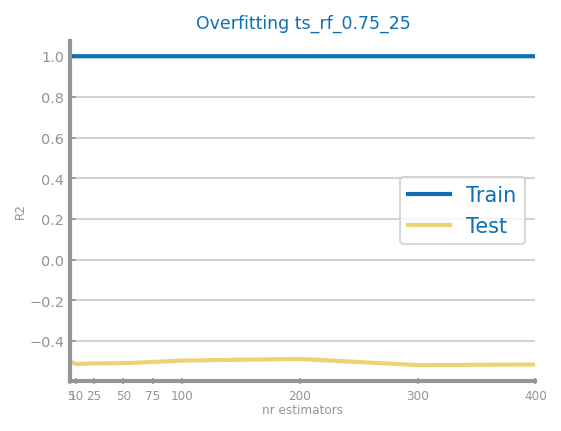

In [23]:
y_tst_values = []
y_trn_values = []
for k in n_estimators:
    pred = RandomForestRegressor(n_estimators=best[2], max_depth=best[1], max_features=best[0])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'ts_rf_{best[0]}_{best[1]}', xlabel='nr estimators', ylabel=measure, pct=flag_pct)

## 05 - GradientBoosting

As before, Gradient Boosting, implemented through the GradientBoostingRegressorr in the sklearn.ensemble package, is anoother powerful prediction technique.

Like random forests for prediction, it trains a set of n regression trees, that are combined in an ensemble of n_estimators. Each tree, however, is trained over the original dataset and usually has a fixed maximum depth. Beside many other parameters we can choose the maximum tree depth, learning rate and critirion to use, through max_depth, learning_rate and criterion parameters, respectively. And we are able to choose the Loss function to be optimized during the training, setting the parameter loss.

In [24]:
learning_rate = [.1, .5, .9]
max_depths = [5, 10, 15, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]

measure = 'R2'
flag_pct = False
best = ('',  0, 0.0)
last_best = -10000
best_model = None
ncols = len(learning_rate)

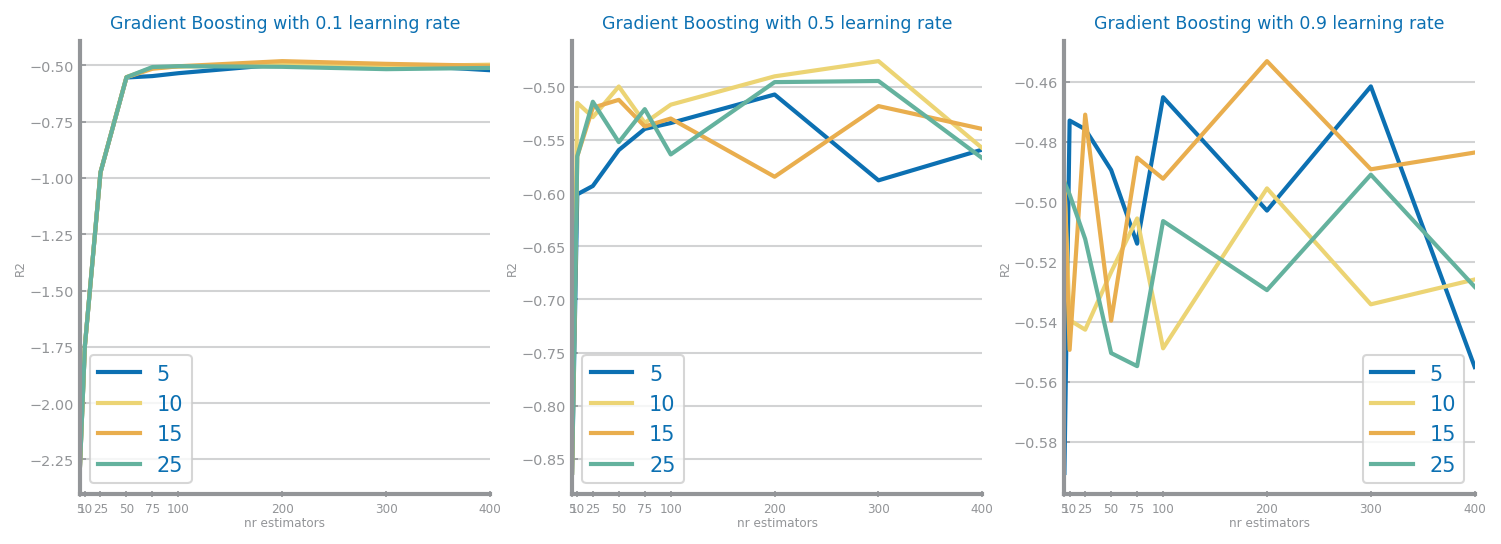

Best results achieved with 0.9 learning rate, depth=15 and nr estimators=200 ==> measure=-0.45


In [25]:
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for nr_lr in range(len(learning_rate)):
    lr = learning_rate[nr_lr]
    values = {}
    for d in max_depths:
        yvalues = []
        for n in n_estimators:
            # print(f'GB - learning rate={lr} depth={d} and nr_estimators={n}')
            pred = GradientBoostingRegressor(n_estimators=n, max_depth=d, learning_rate=lr, loss='absolute_error')
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (lr, d, n)
                last_best = yvalues[-1]
                best_model = pred

        values[d] = yvalues
    multiple_line_chart(
        n_estimators, values, ax=axs[0, nr_lr], title=f'Gradient Boosting with {lr} learning rate', xlabel='nr estimators', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_gb_study.png')
show()
print(f'Best results achieved with {best[0]} learning rate, depth={best[1]} and nr estimators={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.006739205376924583, 1.1949765792039775], 'MAE': [0.0014596050912200687, 0.8132708351429905]} {'R2': [0.999799271858197, -0.45315944115362283]}


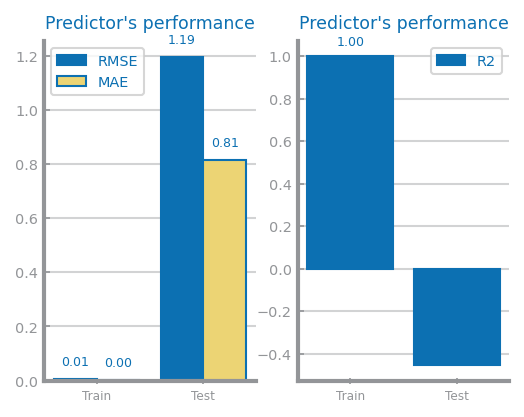

In [26]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_gb_best.png')

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

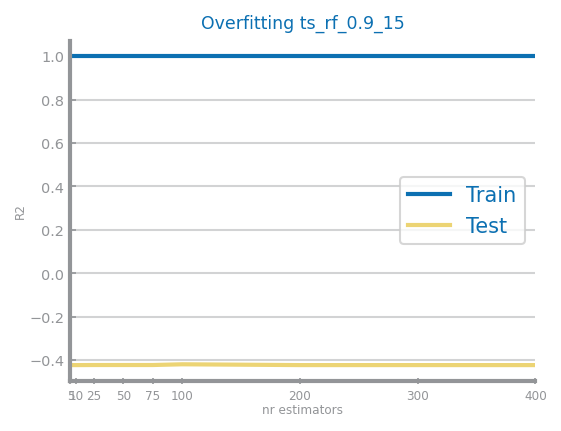

In [27]:
y_tst_values = []
y_trn_values = []
for k in n_estimators:
    pred = GradientBoostingRegressor(n_estimators=best[2], max_depth=best[1], learning_rate=best[0])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'ts_rf_{best[0]}_{best[1]}', xlabel='nr estimators', ylabel=measure, pct=flag_pct)

## 06 - Multi Layer Perceptrons

Multi Layer Perceptrons are the usual representation used by neural networks for dealing with multidimensional data. In the context of prediction, in Python, they are implemented through the MLPRegressor in the sklearn.neural_network. And its use is similar for both classification and prediction.

In [28]:
lr_type = ['constant'] #, 'invscaling', 'adaptive'] - only used if optimizer='sgd'
learning_rate = [.9, .6, .3, .1]
max_iter = [100, 150, 250, 500, 1000]
max_iter_warm_start = [max_iter[0]]
for el in max_iter[1:]:
    max_iter_warm_start.append(max_iter_warm_start[-1]+el)

measure = 'R2'
flag_pct = False
best = ('',  0, 0.0)
last_best = -10000
best_model = None
ncols = len(lr_type)

In [29]:
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(lr_type)):
    tp = lr_type[k]
    values = {}
    for lr in learning_rate:
        yvalues = []
        warm_start = False
        for n in max_iter:
            # print(f'MLP - lr type={tp} learning rate={lr} and nr_episodes={n}')
            pred = MLPRegressor(
                learning_rate=tp, learning_rate_init=lr, max_iter=n,
                activation='relu', warm_start=warm_start, verbose=False)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            warm_start = True
            if yvalues[-1] > last_best:
                best = (tp, lr, n)
                last_best = yvalues[-1]
                best_model = pred
        values[lr] = yvalues

    multiple_line_chart(
        max_iter_warm_start, values, ax=axs[0, k], title=f'MLP with lr_type={tp}', xlabel='mx iter', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_mlp_study.png')
show()
print(f'Best results with lr_type={best[0]}, learning rate={best[1]} and {best[2]} max iter ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.09691929783016982, 0.15287514822614454], 'MAE': [0.06940866985716304, 0.11758257637415208]} {'MAPE': [0.9352901957017438, 0.6899006062536426], 'R2': [0.95913499389348, 0.9282267429994513]}


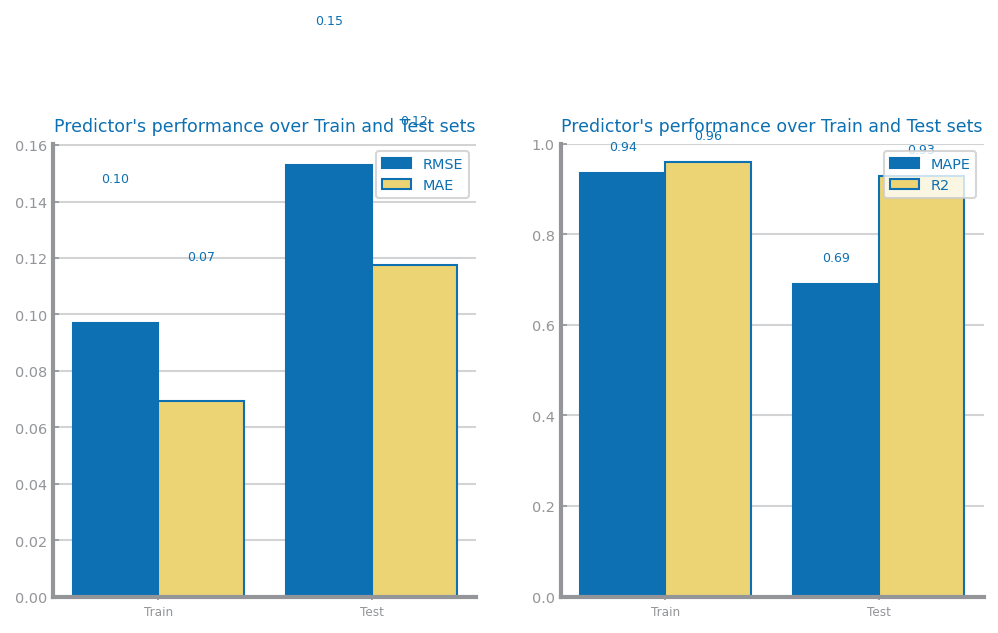

In [ ]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_mlp_best.png')

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

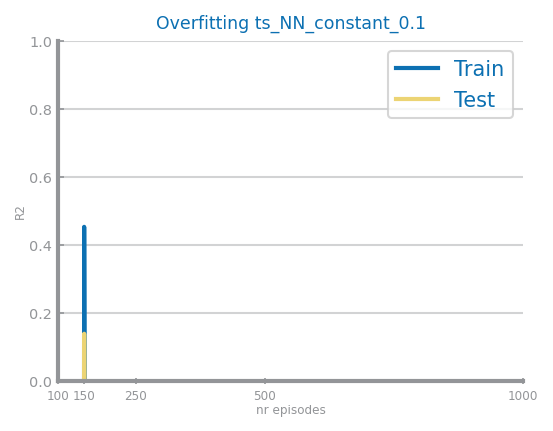

In [ ]:
y_tst_values = []
y_trn_values = []
warm_start = False
for n in max_iter:
    # print(f'MLP - lr type={best[1]} learning rate={best[0]} and nr_episodes={n}')
    MLPRegressor(
        learning_rate=best[0], learning_rate_init=best[1], max_iter=n,
        activation='relu', warm_start=warm_start, verbose=False)
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
    warm_start = True
plot_overfitting_study(max_iter, y_trn_values, y_tst_values, name=f'ts_NN_{best[0]}_{best[1]}', xlabel='nr episodes', ylabel=measure, pct=flag_pct)

## 07 - Rolling Mean

{'SimpleAvg': -3.8497390033536636, 'Persistence': 0.997287467152158, 'RollingMean': 0.9981896114901441}
{'RMSE': [0.01242930083514561, 0.03932014666075232], 'MAE': [0.007572549154857964, 0.025545267231456295]} {'R2': [0.9993157298007, 0.9981896114901441]}


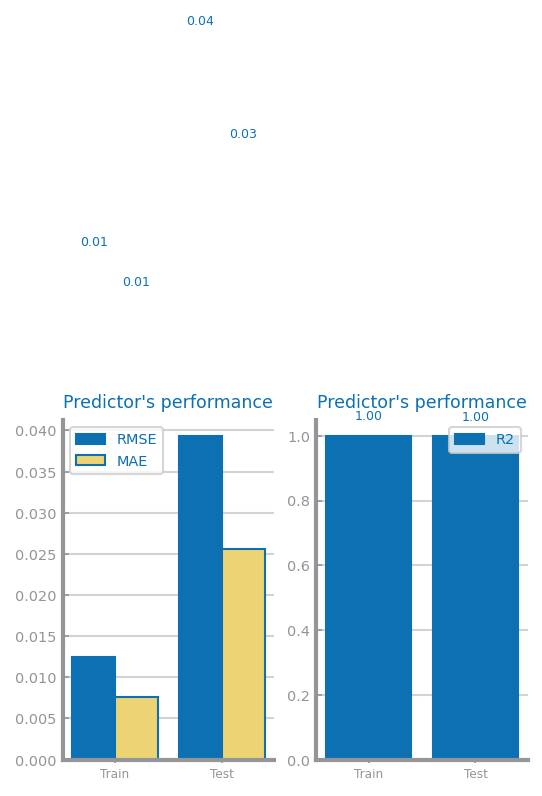

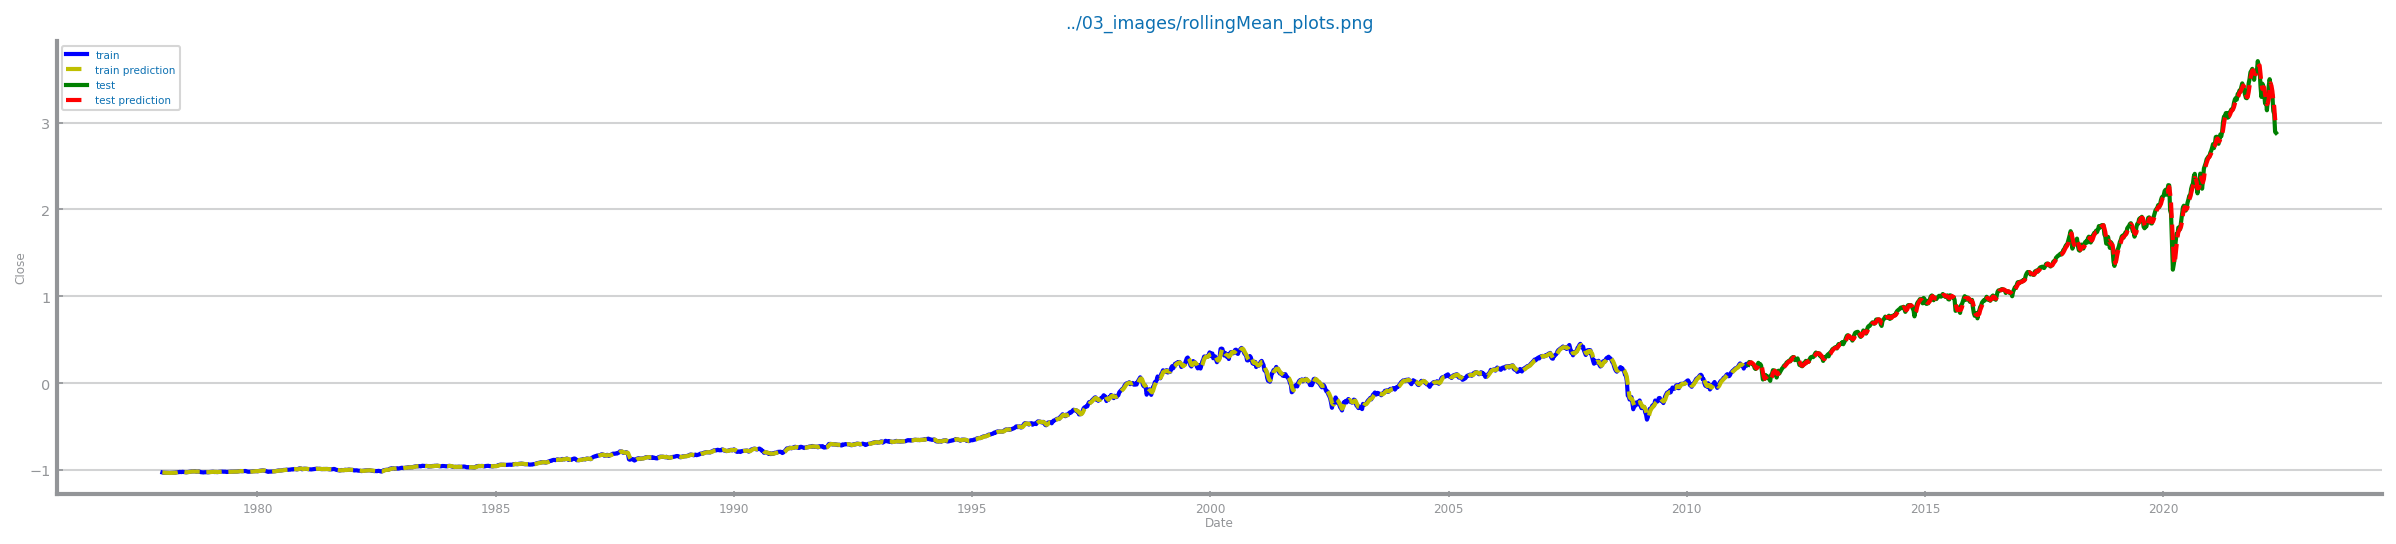

In [ ]:
class RollingMeanRegressor (RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win

    def fit(self, X: DataFrame):
        None

    def predict(self, X: DataFrame):
        prd = len(X) * [0]
        for i in range(len(X)):
            prd[i] = X[max(0, i-self.win_size+1):i+1].mean()
        return prd

fr_mod = RollingMeanRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['RollingMean'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'../03_images/rollingMean_eval.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'../03_images/rollingMean_plots.png', x_label=time_var, y_label=target)

## 08 - ARIMA

ARIMA receives three mandatory parameters p, d, q, but it works a little different from the other estimators we have been using from sklearn, since it is implemented in the statsmodels.tsa package.

Like before we create the ARIMA object, but now we pass the data to model and the parameters to use. After this we fit the model, which is returned as a ARIMAResults object, which can be summarized and plotted in a fashionable way through the plot_diagnostics method.

In [173]:
data.index.freq = 'W-MON'

/Users/miguelfigueiredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/miguelfigueiredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/miguelfigueiredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


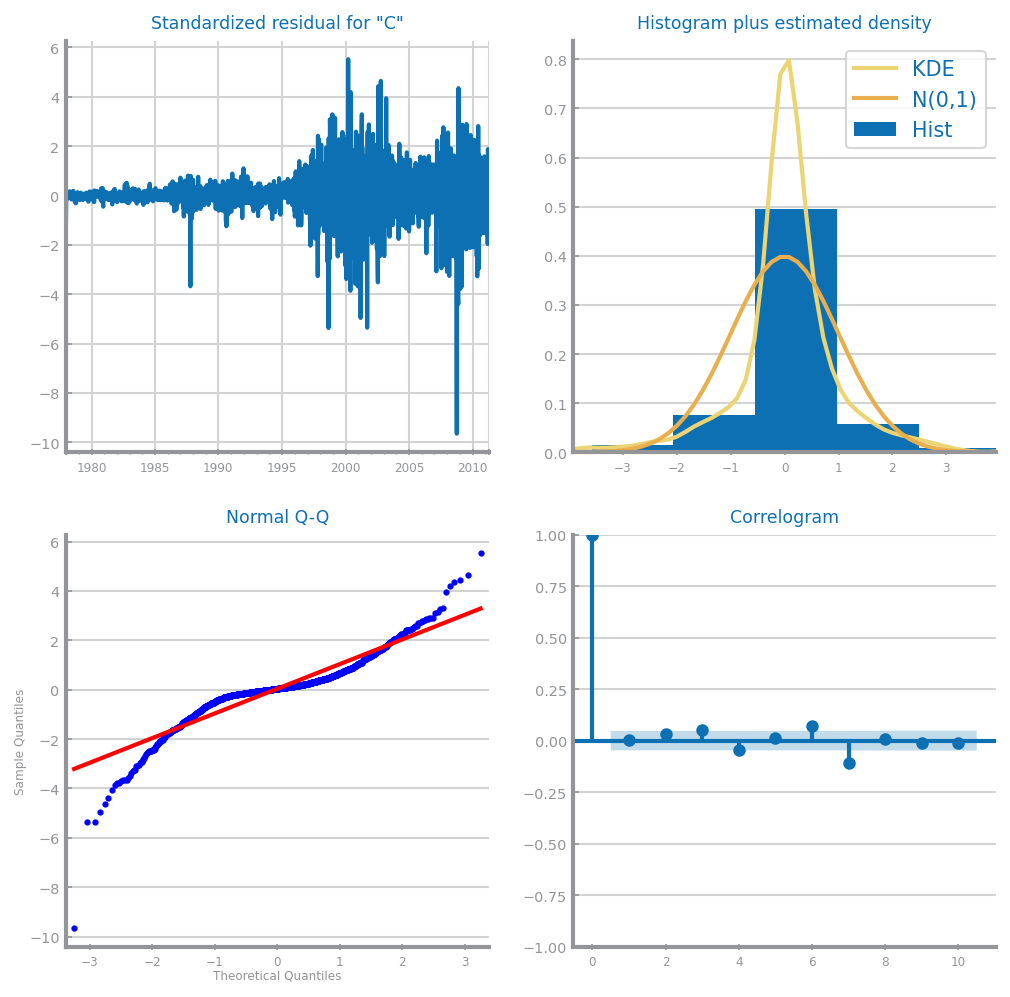

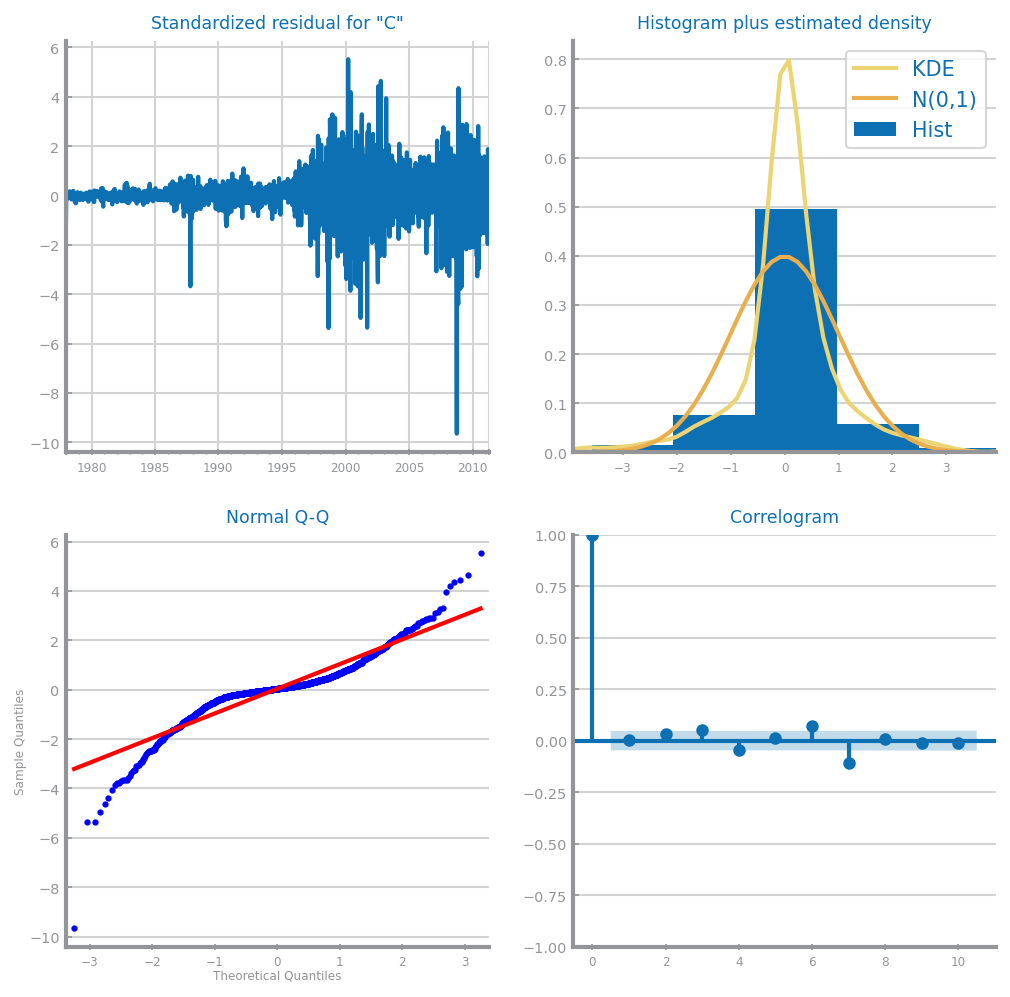

In [174]:
pred = ARIMA(train, order=(2, 0, 2))
model = pred.fit(method_kwargs={'warn_convergence': False})
model.plot_diagnostics(figsize=(2*HEIGHT, 2*HEIGHT))

which shows the following plots (ordered clockwise from top left):
- Standardized residuals over time
- Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
- Normal Q-Q plot, with Normal reference line.
- Correlogram

So, as usual, in order to find the best model, we need to look for tthe best (p, d, q) parameters...

In [175]:
measure = 'R2'
flag_pct = False
last_best = -100
best = ('',  0, 0.0)
best_model = None

d_values = (0, 1, 2)
params = (1, 2, 3, 5)
ncols = len(d_values)

/Users/miguelfigueiredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/miguelfigueiredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/miguelfigueiredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/miguelfigueiredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/migue

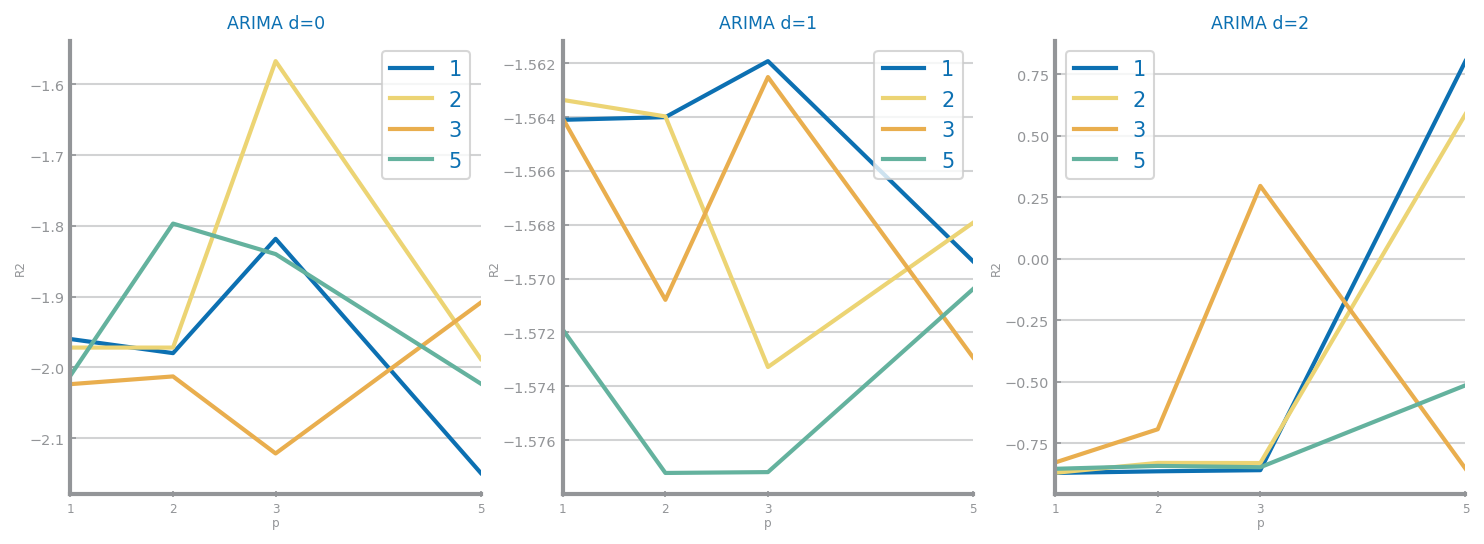

Best results achieved with (p,d,q)=(5, 2, 1) ==> measure=0.80


In [176]:
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for der in range(len(d_values)):
    d = d_values[der]
    values = {}
    for q in params:
        yvalues = []
        for p in params:
            pred = ARIMA(train, order=(p, d, q))
            model = pred.fit(method_kwargs={'warn_convergence': False})
            prd_tst = model.forecast(steps=len(test), signal_only=False)
            yvalues.append(PREDICTION_MEASURES[measure](test,prd_tst))
            if yvalues[-1] > last_best:
                best = (p, d, q)
                last_best = yvalues[-1]
                best_model = model
        values[q] = yvalues
    multiple_line_chart(
        params, values, ax=axs[0, der], title=f'ARIMA d={d}', xlabel='p', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_arima_study.png')
show()
print(f'Best results achieved with (p,d,q)=({best[0]}, {best[1]}, {best[2]}) ==> measure={last_best:.2f}')

And now we can see the best model and its performance.

	R2=0.804023673862601
{'RMSE': [0.031801561075820356, 0.4091014725329128], 'MAE': [0.010314336241989639, 0.24097037956667652]} {'R2': [0.9955204838634467, 0.804023673862601]}


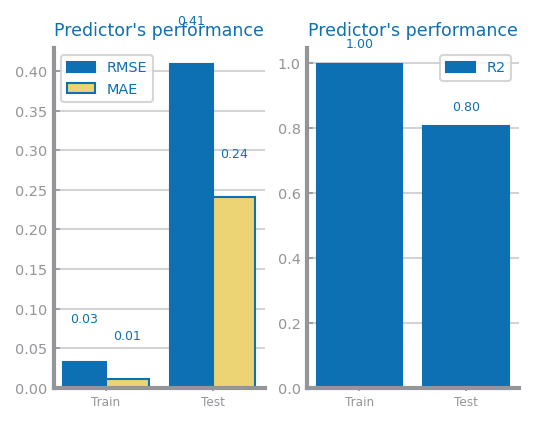

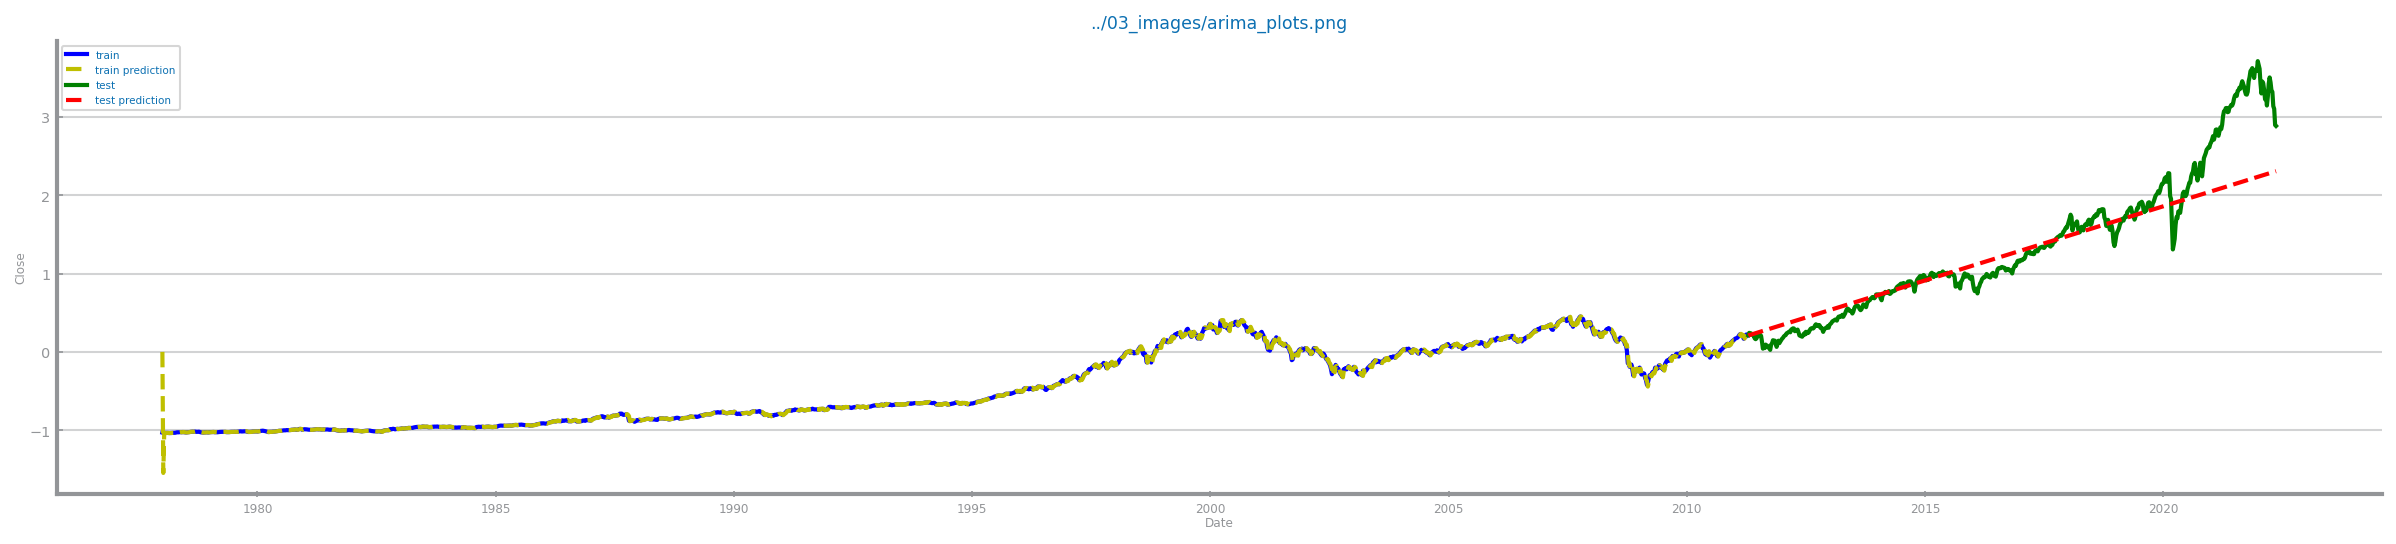

In [177]:
prd_trn = best_model.predict(start=0, end=len(train)-1)
prd_tst = best_model.forecast(steps=len(test))
print(f'\t{measure}={PREDICTION_MEASURES[measure](test, prd_tst)}')

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'../03_images/arima_eval.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'../03_images/arima_plots.png', x_label=time_var, y_label=target)

## 09 - LSTM

There are two major implementations of LSTMs, and we are using the one available through pytorch one, which can be imported through torch.nn package.

In order to simplify the task, lets define a class DS_LSTM to encapsulate our implementation.